In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
import random
import skops.io as sio
import itertools as it
from sklearn.metrics import top_k_accuracy_score, average_precision_score, log_loss, accuracy_score
from IPython.display import display, clear_output, HTML
import gc

## Classificação de imagens reais e falsas

### Dataset 
O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB

Os dados são números inteiros de 0 a 255 representando o valor de cada pixel, para normalizar os dados precisamos apenas dividir todos os valores por 255

In [16]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3)) / 255
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3)) / 255
print(test_x.shape, train_x.shape)

(20000, 32, 32, 3) (100000, 32, 32, 3)


Os dados estão distribuídos de forma que a primeira metade dos dados faz parte da classe falsa e a segunda metade da classe real. Os vetores y são preenchidos com 0s e 1s de acordo com as classes

In [17]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


### Imagens do dataset
As imagens que compõem o dataset são imagens de aviões, automóveis, pássaros, cervos, gatos, cachorros, sapos, cavalos, navios e caminhões. Todas as imagens tem características diferentes não seguindo padrões aparentes

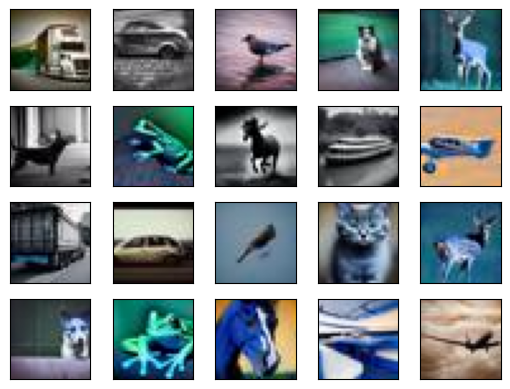

In [18]:
for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x[i-1])


In [19]:
def auxiliar_indexes(data_size, aux_data_size):
    aux_data_size = int(aux_data_size/2)
    half = int(data_size / 2)
    indexes = list(range(half-aux_data_size, half+aux_data_size))
    random.shuffle(indexes)
    return indexes


In [20]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

In [21]:
aux_test_i = auxiliar_indexes(len(flat_test_x), 400)
aux_train_i = auxiliar_indexes(len(flat_train_x), 2000)


### Rede Neural Artificial(RNN)

In [22]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, PReLU, ReLU, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy
from keras.initializers import RandomNormal, Zeros

In [23]:
layerCounts = [1,2,3,4]
ann_scores = []
iterations = 20
if not os.path.exists('ann_files/ann_scores'):
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 10000) for _ in range(iterations)]
    for layer in layerCounts: 
        for i in it.product([50], repeat=layer):
            mean = []
            for m in range(iterations):
                ann_model = Sequential()
                for k in i:
                    ann_model.add(Dense(k, activation="relu"))
                ann_model.add(Dense(2, "sigmoid"))
                ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
                ann_model.fit(flat_train_x[b[m]], train_y[b[m]], epochs=5, use_multiprocessing=True, verbose=False)
                mean.append(ann_model.evaluate(flat_test_x[a[m]], test_y[a[m]], use_multiprocessing=True, verbose=False)[1])
                gc.collect()
            ann_scores.append(mean)


In [24]:
ann_scores = sio.loads(sio.load("ann_files/ann_scores", trusted=True), trusted=True)
if not os.path.exists('ann_files/ann_scores'):
    sio.dump(sio.dumps(ann_scores), "ann_files/ann_scores")


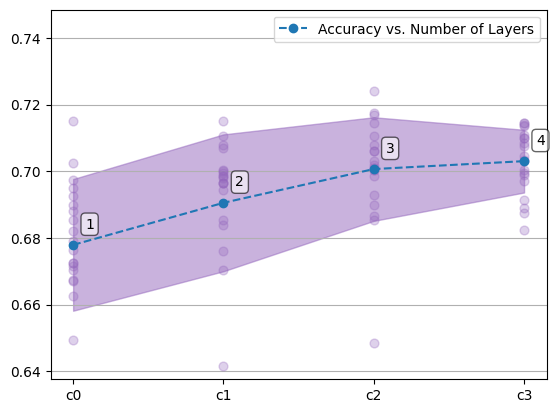

In [25]:
ann_scores_avg = [np.mean(i) for i in ann_scores]
plt.plot([f'c{i}' for i in range(len(ann_scores))], ann_scores_avg, '--o', label='Accuracy vs. Number of Layers', zorder=3)
plt.legend()
points_x = [np.full((len(ann_scores[0]),),x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='C4', alpha=0.3, s=40, zorder=2)
std_ann = np.std(ann_scores, axis=1)
plt.fill_between(range(len(ann_scores)), ann_scores_avg+std_ann, ann_scores_avg-std_ann, color="C4", alpha=0.5)
plt.grid(axis='y')
for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(layerCounts[x]), (x+0.08, y+0.005), bbox={'boxstyle': "round", 'fc': "white", "alpha": 0.6})
plt.ylim([np.mean(ann_scores_avg)*0.92, np.mean(ann_scores_avg)*1.08])
None

In [26]:
layerCount = layerCounts[np.argmax([np.mean(x) for x in ann_scores])]

In [27]:
ann_scores = []
iterations = 20
outputSizes = [list(it.repeat(x, layerCount)) for x in [32,64,128,256]]
outputSizes.append([32, 64, 128, 256])
outputSizes.append([256, 128, 64, 32])

if not os.path.exists('ann_files/ann_scores1'):
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 10000) for _ in range(iterations)]
    for i in outputSizes:
        mean = []
        for m in range(iterations):
            ann_model = Sequential()
            for k in i:
                ann_model.add(Dense(k, activation="relu"))
            ann_model.add(Dense(2, "sigmoid"))
            ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
            ann_model.fit(flat_train_x[b[m]], train_y[b[m]], epochs=5, use_multiprocessing=True, verbose=False)
            mean.append(ann_model.evaluate(flat_test_x[a[m]], test_y[a[m]], use_multiprocessing=True, verbose=False)[1])
        ann_scores.append(mean)


In [28]:
ann_scores = sio.loads(sio.load("ann_files/ann_scores1", trusted=True), trusted=True)
if not os.path.exists('ann_files/ann_scores1'):
    sio.dump(sio.dumps(ann_scores), "ann_files/ann_scores1")


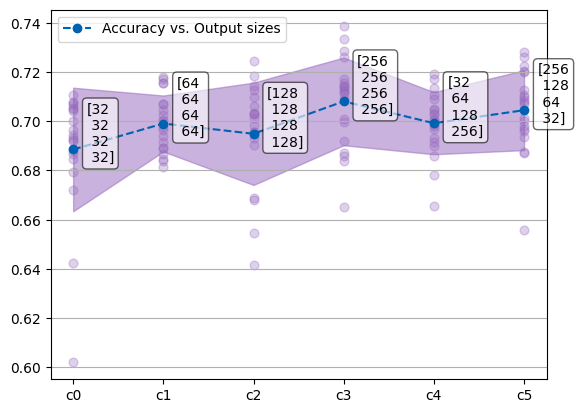

In [29]:
ann_scores_avg = [np.mean(x) for x in ann_scores]
std_ann = np.std(ann_scores, axis=1)
plt.plot([f'c{i}' for i in range(len(ann_scores))], ann_scores_avg,
         '--o', c="#0062b2", label='Accuracy vs. Output sizes')
plt.legend()
points_x = [np.full((len(ann_scores[0]),), x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='C4', alpha=0.3, s=40)
std_ann = np.std(ann_scores, axis=1)
plt.fill_between(range(len(ann_scores)), ann_scores_avg+std_ann,
                 ann_scores_avg-std_ann, color="C4", alpha=0.5)
plt.grid(axis='y')

for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(outputSizes[x]).replace(',', '\n'), (x+0.15, y-0.005),
                 bbox={'boxstyle': "round", 'fc': "white", 'alpha': 0.6})


In [30]:
sizes = outputSizes[np.argmax([np.mean(x) for x in ann_scores])]
print(sizes)

[256, 256, 256, 256]


In [31]:
ann_scores = []
iterations = 20
activations = [ 'leaky2', 'relu', 'leaky1']

if not os.path.exists('ann_files/ann_scores2'):
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 10000) for _ in range(iterations)]
    for i in activations:
        mean = []
        for m in range(iterations):
            ann_model = Sequential()
            for size in sizes:
                ann_model.add(Dense(k))
                if i == "relu":
                    ann_model.add(ReLU())
                elif i == 'leaky1':
                    ann_model.add(LeakyReLU(alpha=0.1))
                else:
                    ann_model.add(LeakyReLU(alpha=0.2))
            ann_model.add(Dense(2, "sigmoid"))
            ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
            ann_model.fit(flat_train_x[b[m]], train_y[b[m]], epochs=5, use_multiprocessing=True, verbose=False)
            mean.append(ann_model.evaluate(flat_test_x[a[m]], test_y[a[m]], use_multiprocessing=True, verbose=False)[1])
            gc.collect()
        ann_scores.append(mean)
        print(ann_scores[-1])

In [32]:
if not os.path.exists('ann_files/ann_scores2'):
    sio.dump(sio.dumps(ann_scores), "ann_files/ann_scores2")


In [33]:
ann_scores = sio.loads(
    sio.load("ann_files/ann_scores2", trusted=True), trusted=True)


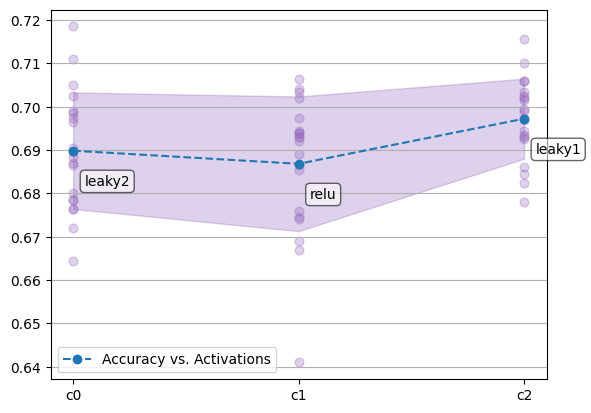

In [34]:
ann_scores_avg = [np.mean(x) for x in ann_scores]
plt.plot([f'c{i}' for i in range(len(ann_scores))],
         [np.mean(x) for x in ann_scores], '--o', label='Accuracy vs. Activations')
plt.legend()
points_x = [np.full((len(ann_scores[0]),), x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='C4', alpha=0.3, s=40)
std_ann = np.std(ann_scores, axis=1)
plt.fill_between(range(len(ann_scores)), ann_scores_avg+std_ann,
                 ann_scores_avg-std_ann, color="C4", alpha=0.3)
plt.grid(axis='y')

for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(activations[x]).replace(',', '\n'), (x+0.05, y-0.008),
                 bbox={'boxstyle': "round", 'fc': "white", 'alpha': 0.6})


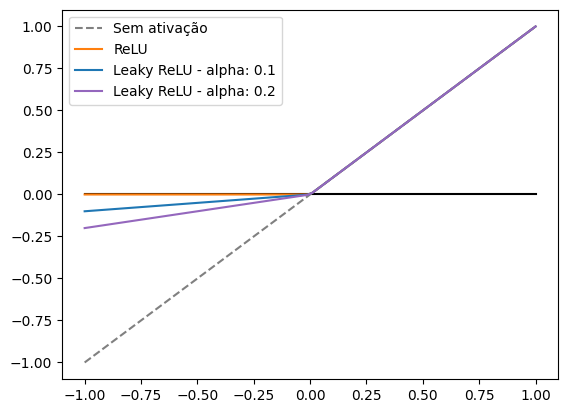

In [35]:
def plot_func(func, name, color, style='-'):
    x = np.linspace(-1, 1, 100)
    y =  func(x)
    plt.plot(x, y, style, label=name, color=color)

plot_func(lambda x: x*0, '', 'k', '-')
plot_func(lambda x: x, 'Sem ativação', 'gray', '--')
plot_func(lambda x: np.maximum(0, x), 'ReLU', 'C1')
plot_func(lambda x: np.maximum(0.1*x, x), 'Leaky ReLU - alpha: 0.1', 'C0')
plot_func(lambda x: np.maximum(0.2*x, x), 'Leaky ReLU - alpha: 0.2', 'C4')
plt.legend()

In [36]:
ann_model = Sequential()

for size in sizes:
    ann_model.add(Dense(size))
    ann_model.add(LeakyReLU(alpha=0.1))
ann_model.add(Dense(2, activation="sigmoid"))

In [37]:
ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

In [38]:
if os.path.exists('ann_files/ann_model'):
    ann_model = load_model('ann_files/ann_model')
    with open('ann_files/ann_fit.txt', 'r') as f:
        print(f.read())
else:
    ann_model.fit(flat_train_x, train_y, epochs=10, validation_split=0.2, use_multiprocessing=True)
    ann_model.save('ann_files/ann_model')


Epoch 1/10
2500/2500 [==============================] - 97s 36ms/step - loss: 0.4772 - acc: 0.7666 - val_loss: 0.9784 - val_acc: 0.4115
Epoch 2/10
2500/2500 [==============================] - 91s 36ms/step - loss: 0.4522 - acc: 0.7823 - val_loss: 0.7151 - val_acc: 0.6288
Epoch 3/10
2500/2500 [==============================] - 54s 22ms/step - loss: 0.4329 - acc: 0.7935 - val_loss: 0.8810 - val_acc: 0.5160
Epoch 4/10
2500/2500 [==============================] - 50s 20ms/step - loss: 0.4180 - acc: 0.8025 - val_loss: 0.7589 - val_acc: 0.6057
Epoch 5/10
2500/2500 [==============================] - 50s 20ms/step - loss: 0.4053 - acc: 0.8094 - val_loss: 0.6058 - val_acc: 0.6692
Epoch 6/10
2500/2500 [==============================] - 56s 22ms/step - loss: 0.3930 - acc: 0.8166 - val_loss: 0.4741 - val_acc: 0.7646
Epoch 7/10
2500/2500 [==============================] - 53s 21ms/step - loss: 0.3809 - acc: 0.8240 - val_loss: 0.5728 - val_acc: 0.6944
Epoch 8/10
2500/2500 [==========================

In [39]:
res = ann_model.evaluate(flat_test_x, test_y, verbose=False)
print(f'Accuracy: {res[1]}')

Accuracy: 0.8187000155448914


In [40]:
ann_proba = ann_model.predict(flat_test_x, use_multiprocessing=True, verbose=False)
sio.dump(sio.dumps(ann_proba), "ann_files/ann_proba.skops")

In [41]:
weights, _ = ann_model.layers[0].get_weights()

In [42]:
def normalize_matrix(matrix):
    mn, mx = matrix.min(), matrix.max()
    if(mn < 0):
        mn *= -1
    else:
        mn = 0
    return (matrix+mn)/(mx+mn)


#### Por que esses valores?

In [57]:

def plot_single_layer(weights, h_start, h_count):
    lim = 6
    v_gap = 1
    h_gap = 1
    v_count = len(weights)
    end_count = len(weights[0])
    h_offset = (lim / 2-(h_gap*(h_count)/2)) + 0 * h_gap
    p = plt.gca()
    for i in range(end_count):
        end = (lim / 2-(v_gap*(end_count-1)/2)) + i * v_gap
        x = np.full((v_count,2), [h_offset+h_start*h_gap, h_offset+h_start*h_gap+h_gap]).flatten()
        y = (np.array(range(v_count)) * v_gap)+(lim /2-(v_gap*(v_count-1)/2))
        y = np.array([list(y), list(it.repeat(end, v_count))]).transpose().flatten()
        widths = np.abs(weights[:, i])
        widths = (widths / np.max(widths))*5
        
        ps = list(np.array([list(x),list(y)]).transpose().flatten())
        ps = np.array(ps).reshape(v_count,2,2)
        
        c_map = ['#dc1471', '#1ca6e2']
        col = LineCollection(ps,
                            linewidths=widths, colors=[c_map[np.argmax([k, 0])] for k in weights[:, i]], capstyle='round')
        
        p.add_collection(col)
        p.set_xlim(0,lim)
        p.set_ylim(0,lim)
        plt.xticks([])
        plt.yticks([])
        p.scatter(x,y, s=100, c="C1", zorder=3)
    
    plt.legend([plt.Line2D([0], [0], color=c_map[0]),
                plt.Line2D([0], [0], color=c_map[1])], ['Positive', 'Negative'], loc='upper right')

        

In [52]:
def plot_layers(layers):
    for i, j in zip(range(len(layers)), range(len(layers), 0, -1)):
        plot_single_layer(np.array(layers[i][:j+1, :j]), i, len(layers))

In [53]:
weights_plot = []
if os.path.exists("ann_files/ann_weights.skops"):
   weights_plot = sio.loads(sio.load("ann_files/ann_weights.skops"))
else:
   ann_model = Sequential()

   for size in sizes:
      ann_model.add(Dense(size))
      ann_model.add(LeakyReLU(alpha=0.1))
   ann_model.add(Dense(2, activation="sigmoid"))
   ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'], )
   b = [auxiliar_indexes(len(flat_train_x), 30000) for _ in range(10)]
   for x in range(10):   
      ann_model.fit(flat_train_x[b[x]], train_y[b[x]], epochs=1, use_multiprocessing=True, verbose=False)
      model_weights = []
      for i in range(0, len(ann_model.layers), 2):
         w, _ = ann_model.layers[i].get_weights()
         model_weights.append(w)
      weights_plot.append(model_weights)
   sio.dump(sio.dumps(weights_plot), "ann_files/ann_weights.skops")



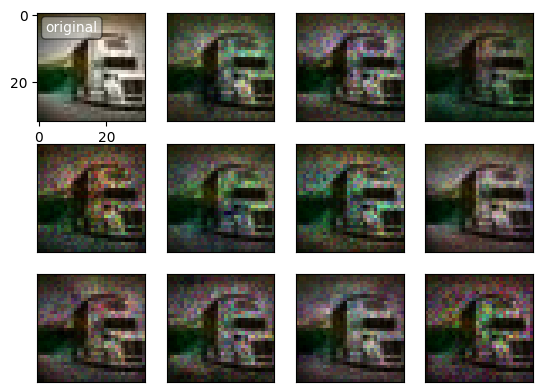

In [47]:
plt.subplot(3, 4, 1)
plt.imshow(test_x[0])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})
for i in range(2, 13):
    processed_img = weights[:, i-2].reshape(32, 32, 3)
    processed_img = normalize_matrix(processed_img)
    processed_img = np.multiply(processed_img, test_x[0])
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(processed_img)


In [48]:
processed_img = Sequential(layers=ann_model.layers[:2]).predict(flat_test_x[:1])
processed_img = normalize_matrix(processed_img.reshape((16, 16)))


1/1 [==============================] - 0s 295ms/step


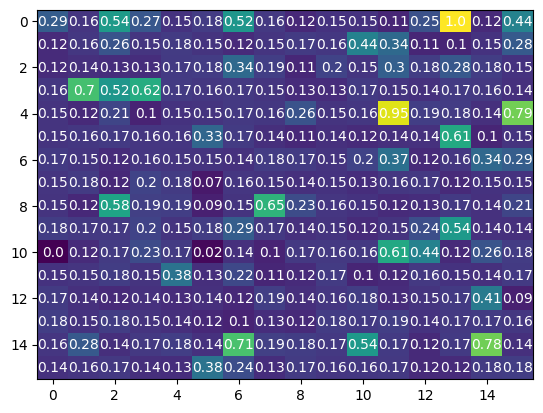

In [49]:
plt.imshow(processed_img, interpolation='nearest', aspect='auto')

for x in range(len(processed_img)):
    for y in range(len(processed_img[x])):
            plt.text(y,x, round(processed_img[x][y], 2), ha="center",va='center', color="w")

In [58]:
def animate(i):
    plt.gca().clear()
    plot_layers(weights_plot[i])
    plt.annotate(str(i), [0.1,0.2], bbox={'fc': 'white'})

ani = FuncAnimation(plt.gcf(), animate, frames=10, interval=1000, cache_frame_data=False)
display(HTML(ani.to_jshtml()))
plt.close()